# Notice: Execute on GPU P100 on kaggle

# Explanation:
generate_baseline_multihop - execute prompts without patching


evaluate_attriburte_exraction_batch_multihop - the patching method


run_experiment- call the patching for all the combinations of layers

generate_CoT_data_v7 - create the prompts data set


step_by_step_cot_baseline - the chain pf thought method



In [1]:
!git clone https://github.com/meshyochana/nlp-final.git#https://github.com/PAIR-code/interpretability.git

NameError: name 'clone' is not defined

In [2]:
%cd /kaggle/working/interpretability/patchscopes/code
!pwd


/kaggle/working/interpretability/patchscopes/code

/kaggle/working/interpretability/patchscopes/code


In [3]:
!ls

README.md			multihop-CoT.ipynb

apply_delta.py			next_token_prediction.ipynb

attribute_extraction.ipynb	patch_cross_model.ipynb

download_the_pile_text_data.py	patchscopes_utils.py

entity_processing.ipynb		preprocessed_data

general_utils.py		requirements.txt

images


In [4]:
import torch
print(torch.cuda.device_count())

1


# Install all repo requirments

In [5]:
import pkg_resources
import subprocess
import sys

# List of required packages and their versions
required_packages = {
#     'torch': 'torch==1.12.1+cu113',
#     'pandas': 'pandas==2.0.3',
#     'numpy': 'numpy==1.25.2',
    'datasets': 'datasets==2.14.7',
#     'zstandard': 'zstandard==0.22.0',
#     'transformers': 'transformers==4.34.1',
#     'nltk': 'nltk==3.8.1',
#     'rouge_score': 'rouge_score==0.1.2',
#     'sentencepiece': 'sentencepiece==0.1.99',
#     'huggingface_hub': 'huggingface_hub==0.17.3',
#     'accelerate': 'accelerate==0.24.1',
#     'altair': 'altair==5.1.2'
}

# Function to check and install the required package
def install_package(package_name, package_version):
    try:
        # Only the package name should be used to check its presence, not the version
        pkg_resources.get_distribution(package_name)
        print(f"{package_name} is already installed")
    except pkg_resources.VersionConflict as e:
        print(f"Version conflict: {e}. Attempting to install the correct version.")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_version])
    except pkg_resources.DistributionNotFound:
        # Package not found, so install it
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_version])

# Loop through the required packages and install them if they are not installed
for package, version in required_packages.items():
    install_package(package, version)


/tmp/ipykernel_35/3188415793.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html

  import pkg_resources


datasets is already installed


In [6]:
from ast import literal_eval
import functools
import json
import os
import random
import shutil

# Scienfitic packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import torch
import datasets
from torch import cuda
import tqdm
torch.set_grad_enabled(False)

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook",
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities

from general_utils import (
  ModelAndTokenizer,
  make_inputs,
  decode_tokens,
  find_token_range,
  predict_from_input,
)

from patchscopes_utils import *

from tqdm import tqdm
tqdm.pandas()

In [7]:
from torch.nn import BCELoss, DataParallel
# Load model
model_name = "/kaggle/input/llama-2/pytorch/7b-chat-hf/1"
sos_tok = False

if "13b" in model_name or "12b" in model_name or "7b" in model_name:
    torch_dtype = torch.float16
else:
    torch_dtype = None

my_device = torch.device("cuda:0")

mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=torch_dtype,
    device=my_device,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/transformers/generation/configur

In [8]:
def set_hs_patch_hooks_llama_batch_omer(
    model,
    hs_patch_config,
    module="hs",
    patch_input=False,
    generation_mode=False,
):
  """LLAMA patch hooks - supporting batch."""
  # when using mode.generate() the hidden states in the input are cached after
  # the first inference pass, and in the next steps the input/output are of
  # size 1. In these cases we don't need to patch anymore the previous hidden
  # states from the initial input, because they are cached, but we do need to
  # handle these cases in this call because this hook wraps the generation call.
  #
  # NOTE: To use generation mode, we must patch a position that is not the
  # first one. This is because in this case we don't know during generation if
  # we are handling the initial input or a future step and thus don't know if
  # a patching is needed or not.

  # if generation_mode:
  #     for i in hs_patch_config:
  #         for position_, _ in hs_patch_config[i]:
  #             assert position_ > 0

  if module != "hs":
    raise ValueError("Module %s not yet supported", module)

  def patch_hs(name, position_hs, patch_input, generation_mode):
    def pre_hook(module, inp):
      # inp[0]: (batch, sequence, hidden_state)
      idx_, position_, hs_ = (
          position_hs["batch_idx"],
          position_hs["position_target"],
          position_hs["hidden_rep"],
      )
      input_len = len(inp[0][idx_])
      if generation_mode and input_len == 1:
        return
      inp[0][idx_][position_] = hs_

    def post_hook(module, inp, output):
      idx_, position_, hs_ = (
          position_hs["batch_idx"],
          position_hs["position_target"],
          position_hs["hidden_rep"],
      )
      if "skip_ln" in name:
        # output: (batch, sequence, hidden_state)
        output_len = len(output[idx_])
        if generation_mode and output_len == 1:
          return
        output[idx_][position_] = hs_
      else:
        # output[0]: (batch, sequence, hidden_state)
        output_len = len(output[0][idx_])
        if generation_mode and output_len == 1:
          return
        output[0][idx_][position_] = hs_
    if patch_input:
      return pre_hook
    else:
      return post_hook

  hooks = []

  for item in hs_patch_config:
    i = item["layer_target"]
    skip_final_ln = item["skip_final_ln"]
    if patch_input:
      hooks.append(
          model.model.layers[i].register_forward_pre_hook(
              patch_hs(f"patch_hs_{i}", item, patch_input, generation_mode)
          )
      )
    else:
      # when patching a last-layer representation to the last layer of the same
      # model, the final layer norm is not needed because it was already applied
      # (assuming that the representation for patching was obtained by setting
      # output_hidden_representations to True).
      if skip_final_ln and i == len(model.model.layers) - 1:
        hooks.append(
            model.model.norm.register_forward_hook(
                patch_hs(
                    f"patch_hs_{i}_skip_ln", item, patch_input, generation_mode
                )
            )
        )
      else:
        hooks.append(
            model.model.layers[i].register_forward_hook(
                patch_hs(f"patch_hs_{i}", item, patch_input, generation_mode)
            )
        )

  return hooks

In [9]:
mt.set_hs_patch_hooks = set_hs_patch_hooks_llama_batch_omer
mt.model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

# MultiHop reasoning experiments

# Explanation: 
Baseline generations are the outputs produced by the language model without any additional intervention or modifications like patching hidden states.

In [10]:
import tqdm
def generate_baseline_multihop(
    mt, df, batch_size=256, max_gen_len=10,
):
    def _generate_baseline_single_batch(batch_df):
        batch_size = len(batch_df)
        cases = [("baseline_hop2", "hop2"),
                 ("baseline_hop3", "hop3"),
                 ("baseline_multihop3", "hop3"),
                ]
        results = {}
        for target_col, object_col in cases:

            target_baseline_batch = np.array(batch_df[target_col])
            object_batch = np.array(batch_df[object_col])


            # Step 0: run the the model on target prompt baseline (having the subject token in input rather than patched)
            # The goal of this step is to calculate whether the model works correctly by default, and to calculate surprisal
            inp_target_baseline = make_inputs(mt.tokenizer, target_baseline_batch, mt.device)
            seq_len_target_baseline = len(inp_target_baseline["input_ids"][0])
            output_target_baseline_toks = mt.model.generate(
                inp_target_baseline["input_ids"],
                max_length=seq_len_target_baseline + max_gen_len,
                pad_token_id=mt.model.generation_config.eos_token_id,
            )[:, seq_len_target_baseline:]
            generations_baseline = decode_tokens(mt.tokenizer, output_target_baseline_toks)
            generations_baseline_txt = np.array([" ".join(sample_gen) for sample_gen in generations_baseline])


            is_correct_baseline = np.array([
                (object_batch[i] in generations_baseline_txt[i] or
                 object_batch[i].replace(" ", "") in generations_baseline_txt[i].replace(" ", ""))
                for i in range(batch_size)
            ])
            results.update(
                {
                f"generations_{target_col}": generations_baseline_txt,
                f"is_correct_{target_col}": is_correct_baseline,
                }
            )

        return results

    results = {}
    n_batches = len(df) // batch_size
    if len(df)%batch_size !=0:
        n_batches +=1
    for i in tqdm.tqdm(range(n_batches)):
        cur_df = df.iloc[batch_size * i : batch_size * (i + 1)]
        batch_results = _generate_baseline_single_batch(cur_df)
        for key, value in batch_results.items():
            if key in results:
                results[key] = np.concatenate((results[key], value))
            else:
                results[key] = value

    return results


# Experiment 1: Multihop Product Company CEO tuples

This is a subset made only from (product, company) and (company, CEO) tuples from the LRE dataset.
We only picked 3 (company, CEO) tuples, and 15 (product, company) tuples for each that the model is more likely to know the answer to.

This is an exploratory experiment. There is a more complete experiment later in the colab.
Hop 1: Product
Hop 2: company
Hop 3: CEO

In [ ]:
multihop_samples = {
    ("Satya Nadella", "Microsoft"): ["WinDbg", ".NET Framework", "Internet Explorer", "MS-DOS", "Office Open XML",
               "TypeScript", "Bing Maps Platform", "Outlook Express", "PowerShell", "Windows 95",
               "Xbox 360", "Zune", "Visual Basic Script", "Virtual Hard Disk", "Robocopy",
              ],
    ("Tim Cook", "Apple"): ["Siri", "App Store", "CarPlay", "MacBook Air", "Xcode",
               "macOS", "iWork", "Safari", "QuickTime", "TextEdit",
               "WebKit", "QuickDraw", "Time Machine (macOS)", "MessagePad", "Macbook Pro",
              ],
    ("Sundar Pichai", "Google"): ["Chromecast", "Chromebook", "Wear OS", "G Suite", "Picasa",
                "WebP Lossless", "General Transit Feed Specification Lossless", "Cloud Spanner", "Android TV", "Android Runtime",
                "Android Jelly Bean", "Android Auto", "App Inventor", "Chromebook Pixel", "Project Ara",
               ]
}

def generate_multihop_data_ceo(fdir_out="./outputs/factual", batch_size=512, max_gen_len=20, replace=False):
    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    fname_out = "multihop_product_company_ceo"
    if not replace and os.path.exists(f"{fdir_out}/{fname_out}.pkl"):
        print(f"File {fdir_out}/{fname_out}.pkl exists. Skipping generation. Reading file...")
        df = pd.read_pickle(os.path.join(fdir_out, f"{fname_out}.pkl"))
        return df
    prompt_source_template = "{} was created by"
    prompt_target_template = "Who is the current CEO of {}"
    sample_id = 0

    print("Step 1: Prepare dataset...")
    records = []

    for key, value in multihop_samples.items():
        hop3, hop2 = key
        for hop1 in value:
            # hop1: Product
            # hop2: Company
            # hop3: CEO
            records.append({
                "sample_id": sample_id,
                "prompt_source": prompt_source_template.replace("{}", hop1),
                "position_source": -1, # always doing next token prediction
                "prompt_target": prompt_target_template,
                "position_target": -1,

                "baseline_hop2":  f"{hop1} was created by", #  hop2
                "baseline_hop3":  f"Who is the current CEO of {hop2}", # hop3
                "baseline_multihop3": f"Who is the current CEO of the company that created {hop1}", # hop3

                "hop1": hop1,
                "hop2": hop2,
                "hop3": hop3,
            })
            sample_id +=1

    # Step 2: Compute baseline generations
    print("Step 2: Compute baseline generations...")
    df = pd.DataFrame.from_records(records)
    eval_results = generate_baseline_multihop(mt, df, batch_size=batch_size, max_gen_len=max_gen_len)
    for key, value in eval_results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, f"{fname_out}.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, f"{fname_out}.pkl"))
    return df

In [ ]:

multihop_df = generate_multihop_data_ceo(batch_size=128, max_gen_len=20)

## The method outlined below performs the patching operation.
Pass transform argument to apply function on the hidden vector

In [81]:
def evaluate_attriburte_exraction_batch_multihop(
    mt, df, batch_size=32, max_gen_len=10, transform=None
):
    def _evaluate_attriburte_exraction_single_batch(batch_df):
        batch_size = len(batch_df)
        prompt_source_batch = np.array(batch_df["prompt_source"])
        prompt_target_batch = np.array(batch_df["prompt_target"])
        layer_source_batch = np.array(batch_df["layer_source"])
        layer_target_batch = np.array(batch_df["layer_target"])
        position_source_batch = np.array(batch_df["position_source"])
        position_target_batch = np.array(batch_df["position_target"])

        object_batch = np.array(batch_df["hop3"])


        # Adjust position_target to be absolute rather than relative
        inp_target = make_inputs(mt.tokenizer, prompt_target_batch, mt.device)
        for i in range(batch_size):
            if position_target_batch[i] < 0:
                position_target_batch[i] += len(inp_target["input_ids"][i])

        # Step 1: run the the model on source without patching and get the hidden representations.
        inp_source = make_inputs(mt.tokenizer, prompt_source_batch, mt.device)
        output_orig = mt.model(**inp_source, output_hidden_states=True)

        # hidden_states size (n_layers, n_sample, seq_len, hidden_dim)
        hidden_rep = [
            output_orig.hidden_states[layer_source_batch[i] + 1][i][
                position_source_batch[i]
            ]
            for i in range(batch_size)
        ]
        if transform is not None:
            for i in range(batch_size):
                print(f"type of hidden_rep[i]: {hidden_rep[i]}")
                hidden_rep[i] = transform(hidden_rep[i])                

        # Step 2: do second run on target prompt, while patching the input hidden state.
        hs_patch_config = [
            {
                "batch_idx": i,
                "layer_target": layer_target_batch[i],
                "position_target": position_target_batch[i],
                "hidden_rep": hidden_rep[i],
                "skip_final_ln": (
                    layer_source_batch[i]
                    == layer_target_batch[i]
                    == mt.num_layers - 1
                ),
            }
            for i in range(batch_size)
        ]
        patch_hooks = mt.set_hs_patch_hooks(
            mt.model, hs_patch_config, patch_input=False, generation_mode=True
        )
        
        
        output = mt.model(**inp_target)

        # NOTE: inputs are left padded,
        # and sequence length is the same across batch
        seq_len = len(inp_target["input_ids"][0])
        output_toks = mt.model.generate(
            inp_target["input_ids"],
            max_length=seq_len + max_gen_len,
            pad_token_id=mt.model.generation_config.eos_token_id,
        )[:, seq_len:]
        generations_patched = decode_tokens(mt.tokenizer, output_toks)
        generations_patched_txt = np.array([
            " ".join(generations_patched[i])
            for i in range(batch_size)
        ])
        is_correct_patched = np.array([
            (object_batch[i] in generations_patched_txt[i]
             or object_batch[i].replace(" ", "") in generations_patched_txt[i].replace(" ", ""))
            for i in range(batch_size)
        ])

        # remove patching hooks
        remove_hooks(patch_hooks)

        cpu_hidden_rep = np.array([hidden_rep[i].detach().cpu().numpy() for i in range(batch_size)])

        results = {
            "generations_patched": generations_patched,
            "is_correct_patched": is_correct_patched,
            "hidden_rep": cpu_hidden_rep,

        }

        return results

    results = {}
    n_batches = len(df) // batch_size
    if len(df)%batch_size !=0:
        n_batches +=1
    for i in tqdm.tqdm(range(len(df) // batch_size)):
        cur_df = df.iloc[batch_size * i : batch_size * (i + 1)]
        batch_results = _evaluate_attriburte_exraction_single_batch(cur_df)
        for key, value in batch_results.items():
            if key in results:
                results[key] = np.concatenate((results[key], value))
            else:
                results[key] = value

    return results

In [82]:
def run_experiment(df, fname_in, fdir_out, fname_out = "multihop", batch_size=512, n_samples=-1,
                   save_output=True, replace=False):
#     print(f"Running experiment on {fname_in}...")
#     if not replace and os.path.exists(f"{fdir_out}/{fname_out}.pkl"):
#         print(f"File {fdir_out}/{fname_out}.pkl exists. Skipping generation. Reading file...")
#         results_df = pd.read_pickle(f"{fdir_out}/{fname_out}.pkl")
#         return results_df
#     df = pd.read_pickle(f"{fname_in}")
    print(f"\tNumber of samples: {len(df)}")

    # BATCHED
    batch = []
    for layer_source in tqdm.tqdm(range(mt.num_layers)):
        for layer_target in range(mt.num_layers):
            for _, row in df.iterrows():
                item = dict(row)
                item.update({
                    "layer_source": layer_source,
                    "layer_target": layer_target,
                })
                batch.append(item)
    experiment_df = pd.DataFrame.from_records(batch)

    if n_samples > 0 and n_samples<len(experiment_df):
        experiment_df = experiment_df.sample(n=n_samples, replace=False, random_state=42).reset_index(drop=True)

    print(f"\tNumber of datapoints for patching experiment: {len(experiment_df)}")

    eval_results = evaluate_attriburte_exraction_batch_multihop(mt, experiment_df, batch_size=batch_size)
    results_df = experiment_df.head(len(eval_results["is_correct_patched"]))
    for key, value in eval_results.items():
        results_df[key] = list(value)

    if save_output:
        if not os.path.exists(fdir_out):
            os.makedirs(fdir_out)
        results_df.to_csv(f"{fdir_out}/{fname_out}.tsv", sep="\t")
        results_df.to_pickle(f"{fdir_out}/{fname_out}.pkl")

    return results_df

In [ ]:
batch_size = 32  # Reduced from 128
run_experiment("./outputs/factual/multihop_product_company_ceo.pkl",
               "./outputs/results/factual",
               fname_out = "multihop_product_company_ceo", batch_size=32, n_samples=-1,
               save_output=True, replace=False)

# Probe

In [ ]:
def probe_baseline(task_type="factual", task_name="multihop_product_company_ceo",
                   fname_input="./outputs/preprocessed_data_ceo/factual/company_ceo.pkl",
                   inp_label_name="object",
                   hidden_states_dir="./outputs/results_ceo",
                   probe_res_dir="./outputs/probe_ceo",
                   label_name = "hop3", seed=42, n_test_samples=2, # test_ratio=0.5, n_samples=4,
                   rewrite=False, only_correct=True):
    fdir = f"{probe_res_dir}/{task_type}"
    fname_pkl = f"{fdir}/{task_name}_only_correct_{only_correct}.pkl"
    if rewrite==False and os.path.exists(fname_pkl):
        print(f"\t{fname_pkl} exists. Skipping generation. Reading file...")
        test_df = pd.read_pickle(fname_pkl)
        return test_df
    print(f"Creating {fname_pkl}...")
    np.random.seed(seed)

    fname_hidden_states = f"{hidden_states_dir}/{task_type}/{task_name}.pkl"

    # Retrieve list of classes from inputs
    inps_df = pd.read_pickle(fname_input)
    classes = np.unique(inps_df[inp_label_name])
    classes_dict = {}
    for idx, cls in enumerate(classes):
        classes_dict[cls] = idx

    # Get saved hiddens
    hiddens_df = pd.read_pickle(fname_hidden_states)
    hiddens_df = hiddens_df.sample(frac=1).reset_index(drop=True)
    if only_correct:
        hiddens_df = hiddens_df[hiddens_df["is_correct_baseline_hop2"]].reset_index(drop=True)
        hiddens_df = hiddens_df[hiddens_df["is_correct_baseline_hop3"]].reset_index(drop=True)
        if len(hiddens_df)<1:
            print(f'\tNo correct predictions for {fname_pkl}. Skipping...')
            return
    sample_ids = np.unique(hiddens_df['sample_id'])
    if len(sample_ids)<4:
        print(f"\tNot enough samples to train a probe for {fname_pkl}. Skipping...")
        return
    np.random.shuffle(sample_ids)
    test_sample_ids = sample_ids[:n_test_samples]
    train_sample_ids = sample_ids[n_test_samples:]
    train_df = hiddens_df[hiddens_df['sample_id'].isin(train_sample_ids)]
    test_df = hiddens_df[hiddens_df['sample_id'].isin(test_sample_ids)]
    xs = np.stack(hiddens_df["hidden_rep"])
    ys = np.array([classes_dict[i] for i in hiddens_df[label_name]])


    train_xs = np.stack(train_df["hidden_rep"])
    train_ys = np.array([classes_dict[i] for i in train_df[label_name]])
    if len(np.unique(train_ys)) < 2:
        print(f"\tNot enough variety to train a probe for {fname_pkl}. Skipping...")
        return
    test_xs = np.stack(test_df["hidden_rep"])
    test_ys = np.array([classes_dict[i] for i in test_df[label_name]])

    clf = LogisticRegression(random_state=seed).fit(train_xs, train_ys)
    predicted_ys = clf.predict(test_xs)
    test_df["object_int"] = test_ys
    test_df["predicted_int"] = predicted_ys
    test_df["predicted"] = classes[predicted_ys]
    test_df["is_correct_probe"] = test_ys == predicted_ys

    if not os.path.exists(fdir):
        os.makedirs(fdir)
    test_df.to_csv(os.path.join(fdir, f"{task_name}_only_correct_{only_correct}.tsv"), sep="\t")
    test_df.to_pickle(os.path.join(fdir, f"{task_name}_only_correct_{only_correct}.pkl"))
    return test_df

In [ ]:
probe_baseline(task_type="factual", task_name="multihop_product_company_ceo",
               fname_input="./preprocessed_data/factual/company_ceo.pkl",
               inp_label_name="object",
               hidden_states_dir="./outputs/results_ceo",
               probe_res_dir="./outputs/probe_ceo",
               label_name = "hop3",
               rewrite=False)

# Plots

In [ ]:
def plot_heatmaps(task_type="factual", task_name="multihop_product_company_ceo", version="v5", _vmin=0, _vmax=1):
    probe_res_fname = f"./outputs/probe_{version}/{task_type}/{task_name}_only_correct_True.pkl"
    probe_df = pd.read_pickle(probe_res_fname)
    plot_ttl = f"{task_type} : {task_name} - {model_name.strip('./')}"
    n_samples = len(probe_df)

    heatmap_patch = probe_df.groupby(['layer_target', 'layer_source'])["is_correct_patched"].mean().unstack()
    ax = sns.heatmap(data=heatmap_patch, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl} \npatch accuracy (# samples: {n_samples})")
    plt.show()
    plt.clf()

    ax = sns.lineplot(data=probe_df, x="layer_source", y="is_correct_probe")
    ax.set_ylim(-0.01, 1.01)
    ax.set_title(f"{plot_ttl} \nprobe accuracy (# samples: {n_samples})")
    plt.show()
    plt.clf()

In [ ]:
def plot_patching_heatmaps(task_type="factual", task_name="multihop_product_company_ceo", version="ceo",
                           _vmin=0, _vmax=1):
    patch_res_fname = f"./outputs/results_{version}/{task_type}/{task_name}.pkl"
    patch_df = pd.read_pickle(patch_res_fname)
    patch_df = patch_df[patch_df["is_correct_baseline_hop2"]].reset_index(drop=True)
    patch_df = patch_df[patch_df["is_correct_baseline_hop3"]].reset_index(drop=True)
    n_samples = len(patch_df)
    if n_samples ==0:
        print(f"No correct predictions for {patch_res_fname}. Skipping...")
        return
    plot_ttl = f"{task_type}: {task_name}\n{model_name.strip('./')}"
    baseline_acc_multihop3 = patch_df["is_correct_baseline_multihop3"].mean()*100
    baseline_acc_hop3 = patch_df["is_correct_baseline_hop3"].mean()*100
    baseline_acc_hop2 = patch_df["is_correct_baseline_hop2"].mean()*100

    heatmap_patched = patch_df.groupby(['layer_target', 'layer_source'])["is_correct_patched"].mean().unstack()
    ax = sns.heatmap(data=heatmap_patched, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl}\nPatching accuracy\nBaseline multihop reasoning accuracy: {baseline_acc_multihop3:.2f}\n(# samples: {n_samples})")
    plt.show()
    plt.clf()

In [ ]:
plot_patching_heatmaps(version="ceo")

In [ ]:
plot_heatmaps(version="v5")

# Experiment 2 : CoT experiment subset

This is a subset made only from (product, company) and (company, CEO) tuples from the LRE dataset.
We only picked 3 (company, CEO) tuples, and 15 (product, company) tuples for each that the model is more likely to know the answer to.

This is an exploratory experiment. There is a more complete experiment later in the colab.
Hop 1: Product
Hop 2: company
Hop 3: CEO

The difference between this and experiment 1 is in the choice of source and target prompt template. In this experiment, concatenation of source and target prompt makes a reasonable query, compared to experiment 1 where they where that wasn't the case.

In [ ]:
multihop_samples = {
    ("Satya Nadella", "Microsoft"): ["WinDbg", ".NET Framework", "Internet Explorer", "MS-DOS", "Office Open XML",
               "TypeScript", "Bing Maps Platform", "Outlook Express", "PowerShell", "Windows 95",
               "Xbox 360", "Zune", "Visual Basic Script", "Virtual Hard Disk", "Robocopy",
              ],
    ("Tim Cook", "Apple"): ["Siri", "App Store", "CarPlay", "MacBook Air", "Xcode",
               "macOS", "iWork", "Safari", "QuickTime", "TextEdit",
               "WebKit", "QuickDraw", "Time Machine (macOS)", "MessagePad", "Macbook Pro",
              ],
    ("Sundar Pichai", "Google"): ["Chromecast", "Chromebook", "Wear OS", "G Suite", "Picasa",
                "WebP Lossless", "General Transit Feed Specification Lossless", "Cloud Spanner", "Android TV", "Android Runtime",
                "Android Jelly Bean", "Android Auto", "App Inventor", "Chromebook Pixel", "Project Ara",
               ]
}


def generate_CoT_data_prod(fdir_out="./outputs/preprocessed_data_prod_CoT/factual", batch_size=512, max_gen_len=20):
    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    prompt_source_template = "Who is the current CEO of "
    prompt_target_template = "the company that created {}"
    sample_id = 0

    print("Step 1: Prepare dataset...")
    records = []

    for key, value in multihop_samples.items():
        hop3, hop2 = key
        for hop1 in value:
            # hop1: Product
            # hop2: Company
            # hop3: CEO

            records.append({
                "sample_id": sample_id,
                "prompt_source": prompt_source_template,
                "position_source": -1, # always doing next token prediction
                "prompt_target": prompt_target_template.replace("{}", hop1),
                "position_target": -1,

                "baseline_hop2":  f"the company that created {hop1}", #  hop2
                "baseline_hop3":  f"Who is the current CEO of {hop2}", # hop3
                "baseline_multihop3": f"Who is the current CEO of the company that created {hop1}", # hop3

                "hop1": hop1,
                "hop2": hop2,
                "hop3": hop3,
            })
            sample_id +=1

    # Step 2: Compute baseline generations
    print("Step 2: Compute baseline generations...")
    df = pd.DataFrame.from_records(records)
    eval_results = generate_baseline_multihop(mt, df, batch_size=batch_size, max_gen_len=max_gen_len)
    for key, value in eval_results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, "multihop_product_company_ceo.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, "multihop_product_company_ceo.pkl"))

    correct_subset = df[df["is_correct_baseline_hop2"]].reset_index(drop=True)
    correct_subset = correct_subset[correct_subset["is_correct_baseline_hop3"]].reset_index(drop=True)
    correct_subset.to_csv(os.path.join(fdir_out, "multihop_product_company_ceo_only_correct_True.tsv"), sep="\t")
    correct_subset.to_pickle(os.path.join(fdir_out, "multihop_product_company_ceo_only_correct_True.pkl"))
    return df

In [ ]:
multihop2_df = generate_CoT_data_prod(batch_size=128, max_gen_len=20)

In [ ]:
cot_correct_baseline = run_experiment(
    "./outputs/preprocessed_data_prod_CoT/factual/multihop_product_company_ceo_only_correct_True.pkl",
    "./outputs/results_prod_CoT/factual",
    fname_out = "multihop_product_company_ceo_only_correct_True", batch_size=128, n_samples=-1,
    save_output=True, replace=False)

In [ ]:
print("Base MultiHop Accuracy: ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_baseline_multihop3"].max().reset_index()["is_correct_baseline_multihop3"].mean())

print("Patching MultiHop Accuracy: ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())

# Experimet 3: Main CoT experiment

This is the full version, using maximal amount of data possible from LRE where a multihop question can be formed combining two single-hop questions.

In [13]:
!ls preprocessed_data/factual_multihop

multihop_CoT_vicuna-13b-v1.1.tsv


## The method below creates a dataset of multi-hop prompts, each of which the model answered correctly for the two separate hops (combined_multihop_CoT_only_correct_True).

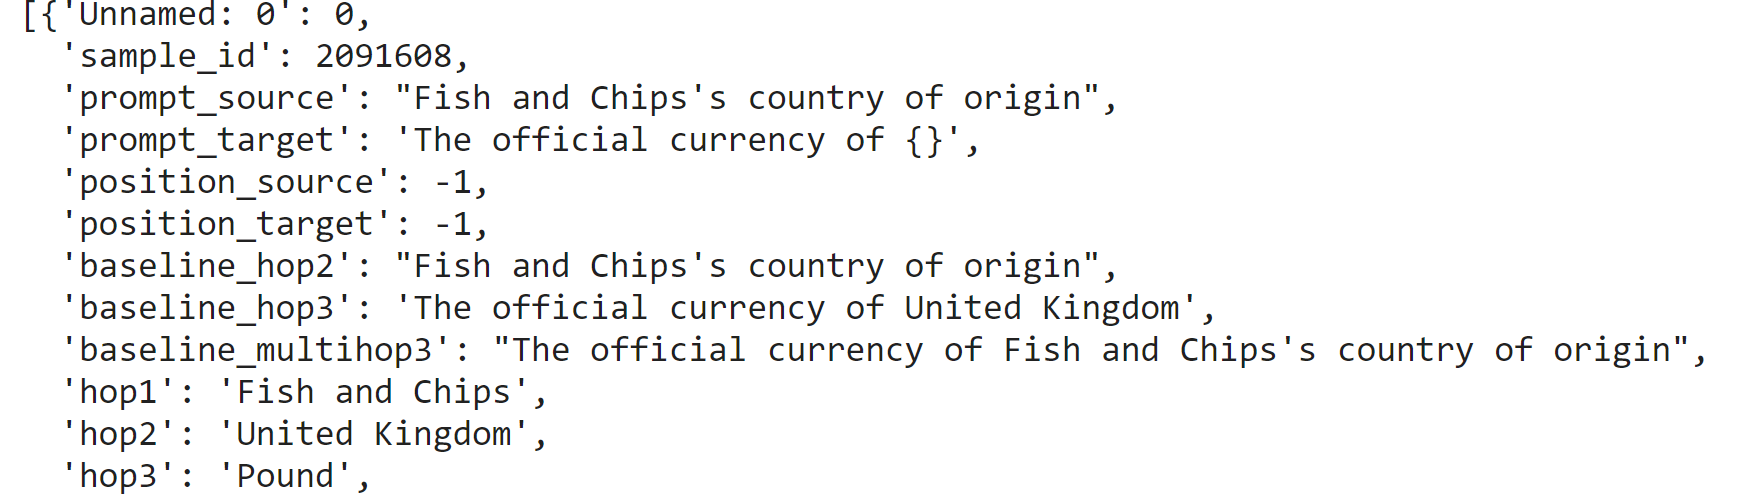

In [14]:
def generate_CoT_data_v7(fname_in="./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop.pkl",
                         fdir_out="./outputs/preprocessed_data_LRE_CoT/factual_multihop", batch_size=512, max_gen_len=20):
    PROMPTS_AMOUNT = 16
    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
#     fname_pkl = f"{fdir_out}/combined_multihop_CoT_only_correct_True.pkl"
#     if os.path.exists(fname_pkl):
#         print(f"File {fname_pkl} exists. Skipping...")
#         return

    print("Step 1: Read multihop dataset created using LRE data prep...")
#     df = pd.read_pickle(fname_in)
    df = pd.read_csv(fname_in, sep='\t')
    df = df.head(PROMPTS_AMOUNT)
    print(f"len of df is {len(df)}")

    # Step 2: Compute baseline generations
    print("Step 2: Compute baseline generations...")
    eval_results = generate_baseline_multihop(mt, df, batch_size=batch_size, max_gen_len=max_gen_len)
    for key, value in eval_results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, f"combined_multihop_CoT.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, f"combined_multihop_CoT.pkl"))

    correct_subset = df[df["is_correct_baseline_hop2"]].reset_index(drop=True)
    correct_subset = correct_subset[correct_subset["is_correct_baseline_hop3"]].reset_index(drop=True)
    correct_subset.to_csv(os.path.join(fdir_out, f"combined_multihop_CoT_only_correct_True.tsv"), sep="\t")
    correct_subset.to_pickle(os.path.join(fdir_out, f"combined_multihop_CoT_only_correct_True.pkl"))
    return df

In [15]:
df = generate_CoT_data_v7(fname_in="./preprocessed_data/factual_multihop/multihop_CoT_vicuna-13b-v1.1.tsv",
                     fdir_out="./outputs/preprocessed_data_LRE_CoT/factual_multihop",
                     batch_size=4, max_gen_len=20)

Step 1: Read multihop dataset created using LRE data prep...



len of df is 16



Step 2: Compute baseline generations...


  0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )



  warnings.warn(



100%|██████████| 4/4 [00:30<00:00,  7.71s/it]


In [16]:
df

,Unnamed: 0,sample_id,prompt_source,prompt_target,position_source,position_target,baseline_hop2,baseline_hop3,baseline_multihop3,hop1,hop2,hop3,layer_source,layer_target,generations_baseline_hop2,is_correct_baseline_hop2,generations_baseline_hop3,is_correct_baseline_hop3,generations_baseline_multihop3,is_correct_baseline_multihop3
0,0,2091608,Fish and Chips's country of origin,The official currency of {},-1,-1,Fish and Chips's country of origin,The official currency of United Kingdom,The official currency of Fish and Chips's coun...,Fish and Chips,United Kingdom,Pound,0,0,is a matter of debate among histor ians and fo...,False,is P ound Ster ling ( GB P ). It is divided in...,True,", the United Kingdom , is the p ound ster ling...",False
1,1,2091854,Masala Dosa's country of origin,The official currency of {},-1,-1,Masala Dosa's country of origin,The official currency of India,The official currency of Masala Dosa's country...,Masala Dosa,India,Rupee,0,0,is a matter of debate among food histor ians a...,False,is the Indian ru pe e ( IN R ). \n \n The Indi...,False,is the Indian ru pe e ( IN R ). \n \n M as ala...,False
2,2,2092064,Biryani's country of origin,The official currency of {},-1,-1,Biryani's country of origin,The official currency of India,The official currency of Biryani's country of ...,Biryani,India,Rupee,0,0,"is India , and it is a popular d ish in many p...",True,is the Indian ru pe e ( IN R ). \n \n The Indi...,False,is the Ru pe e ( IN R ). \n \n B iry ani ' s c...,True
3,3,2092218,Pizza's country of origin,The largest city in {},-1,-1,Pizza's country of origin,The largest city in Italy,The largest city in Pizza's country of origin,Pizza,Italy,Rome,0,0,is Italy . \n \n Answer : Italy </s> </s> </s>...,True,", Milan , has a population of around 1 . 3 mi...",False,"is Nap les , Italy . \n \n The most popular fo...",False
4,4,2092233,Sushi's country of origin,The largest city in {},-1,-1,Sushi's country of origin,The largest city in Japan,The largest city in Sushi's country of origin,Sushi,Japan,Tokyo,0,0,is Japan . \n \n S ush i is a popular Japanese...,True,", Tokyo , is a b ust ling metropol is with a r...",True,is Tokyo . \n \n S ush i is a popular Japanese...,True
5,5,2092310,Poutine's country of origin,The largest city in {},-1,-1,Poutine's country of origin,The largest city in Canada,The largest city in Poutine's country of origin,Poutine,Canada,Toronto,0,0,is Canada . \n \n P out ine is a popular Canad...,True,", Toronto , is a b ust ling metropol is with a...",True,"is Quebec , Canada . \n \n P out ine ' s natio...",False
6,6,2092342,Paella's country of origin,The largest city in {},-1,-1,Paella's country of origin,The largest city in Spain,The largest city in Paella's country of origin,Paella,Spain,Madrid,0,0,. \n \n The country of origin of Pa ella is Sp...,True,", Madrid , is a cultural and economic hub that...",True,"is Val encia , which is located in the eastern...",False
7,7,2092367,Chimichurri's country of origin,The largest city in {},-1,-1,Chimichurri's country of origin,The largest city in Argentina,The largest city in Chimichurri's country of o...,Chimichurri,Argentina,Buenos Aires,0,0,"is Argentina , where it is a popular cond imen...",True,", Buenos Aires , is a b ust ling metropol is w...",True,", Buenos Aires , is known for its v ibr ant ni...",True
8,8,2092404,Feijoada's country of origin,The largest city in {},-1,-1,Feijoada's country of origin,The largest city in Brazil,The largest city in Feijoada's country of origin,Feijoada,Brazil,São Paulo,0,0,is Brazil . \n Fe ijo ada is a traditional Bra...,True,", São Paulo , is located in the sout he astern...",True,is São Paulo . \n \n Fe ijo ada is a tradition...,True
9,9,2092455,Fish and Chips's country of origin,The largest city in {},-1,-1,Fish and Chips's country of origin,The largest city in United Kingdom,The largest city in Fish and Chips's country o...,Fish and Chips,United Kingdom,London,0,0,is a matter of debate among histor ians and f

In [ ]:
cot_correct_baseline = run_experiment(df,
    f"./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop_CoT_only_correct_True.pkl",
    "./outputs/results_LRE_CoT/factual_multihop",
    fname_out = f"combined_multihop_CoT_only_correct_True", batch_size=16, n_samples=-1,
    save_output=True, replace=False)

	Number of samples: 16


100%|██████████| 32/32 [00:02<00:00, 13.40it/s]


	Number of datapoints for patching experiment: 16384


  3%|▎         | 28/1024 [00:55<32:54,  1.98s/it]

In [ ]:
efficient_subset = cot_correct_baseline[cot_correct_baseline["layer_source"]<cot_correct_baseline["layer_target"]].reset_index(drop=True)
# TODO maybe run patching for all source x target, but the killer case is when source < target

print("Base MultiHop Accuracy: ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_baseline_multihop3"].max().reset_index()["is_correct_baseline_multihop3"].mean())

print("General Patching MultiHop Accuracy (all source layer x target layer): ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())


print("Efficient Patching MultiHop Accuracy (source layer < target layer): ",
      efficient_subset.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())


In [ ]:
multihop_fname = "./preprocessed_data/factual_multihop/multihop_CoT_vicuna-13b-v1.1.tsv"
# df = pd.read_pickle(multihop_fname)
df = pd.read_csv(multihop_fname, sep='\t')
print(len(df))

multihop_fname_only_correct = "./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop_CoT_only_correct_True.pkl"
df_only_correct = pd.read_pickle(multihop_fname_only_correct)
print(len(df_only_correct))
# df_only_correct.groupby(['fname_src', 'fname_target']).count()

In [ ]:
def plot_patching_heatmaps_from_df(patch_df, _vmin=0, _vmax=None, fname_postfix="", save_output=True):
    n_samples = len(patch_df)
    plots_dir = "./outputs/multihop_reasoning"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    baseline_acc_multihop3 = patch_df["is_correct_baseline_multihop3"].mean()*100
    patching_acc = patch_df.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean() * 100

    heatmap_patched = patch_df.groupby(['layer_target', 'layer_source'])["is_correct_patched"].mean().unstack()

    FONT_SIZE_TITLE = 16
    FONT_SIZE_AXIS = 15

    plt.figure()
    ax = sns.heatmap(data=heatmap_patched, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"Self-correction in Multi-hop Reasoning\n# samples: {n_samples}", fontsize=FONT_SIZE_TITLE)
    plt.xlabel("Source Layer ($\ell$)", fontsize=FONT_SIZE_AXIS)
    plt.ylabel("Target Layer ($\ell^*$)", fontsize=FONT_SIZE_AXIS)
    plt.tight_layout()
    if save_output:
        fname=f"{plots_dir}/multihop_heatmap{fname_postfix}.pdf"
        plt.savefig(fname, format="pdf", dpi=300, bbox_inches='tight')
        plt.savefig(f"{fname[:-4]}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

In [ ]:
plot_patching_heatmaps_from_df(efficient_subset, fname_postfix="_source_smaller_than_target")

In [ ]:
plot_patching_heatmaps_from_df(cot_correct_baseline)

# Experiment 4 - CoT Let's think step by step baseline. Baseline

How does a "Let's think step by step" CoT baseline compare with the CoT Patchscope?

In [ ]:
def step_by_step_cot_baseline(
    fname_in=f"./preprocessed_data/factual_multihop/combined_multihop_CoT_only_correct_True.pkl",
    fdir_out="./outputs/results_CoT/factual_multihop",
    fname_out = f"combined_multihop_CoT_only_correct_True_step_by_step",
    batch_size=128,
    max_gen_len=20,
    rewrite=False,
    target_col = "baseline_multihop3",
    object_col = "hop3",
    cot_prefix = "Let's think step by step. "):

    if not os.path.exists(fname_in):
        print(f'File {fname_in} does not exist. Skipping...')
        return

    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    fname_pkl = f"{fdir_out}/{fname_out}.pkl"
    if rewrite==False and os.path.exists(fname_pkl):
        print(f"\t{fname_pkl} exists. Skipping generation. Reading file...")
        df = pd.read_pickle(fname_pkl)
        return df

    print("Computing step-by-step baseline generations...")
    df = pd.read_pickle(fname_in)
    df["cot_prefix"] = cot_prefix

    def _generate_baseline_single_batch(batch_df):
        batch_size = len(batch_df)

        results = {}
        target_baseline_batch = np.array(batch_df[target_col])
        target_baseline_batch = np.core.defchararray.add(cot_prefix, target_baseline_batch.astype(str))
        object_batch = np.array(batch_df[object_col])

        inp_target_baseline = make_inputs(mt.tokenizer, target_baseline_batch, mt.device)
        seq_len_target_baseline = len(inp_target_baseline["input_ids"][0])
        output_target_baseline_toks = mt.model.generate(
            inp_target_baseline["input_ids"],
            max_length=seq_len_target_baseline + max_gen_len,
            pad_token_id=mt.model.generation_config.eos_token_id,
        )[:, seq_len_target_baseline:]
        generations_baseline = decode_tokens(mt.tokenizer, output_target_baseline_toks)
        generations_baseline_txt = np.array([" ".join(sample_gen) for sample_gen in generations_baseline])


        is_correct_baseline = np.array([
            (object_batch[i] in generations_baseline_txt[i] or
             object_batch[i].replace(" ", "") in generations_baseline_txt[i].replace(" ", ""))
            for i in range(batch_size)
        ])
        results.update(
            {
            f"step_by_step_generations_{target_col}": generations_baseline_txt,
            f"step_by_step_is_correct_{target_col}": is_correct_baseline,
            }
        )

        return results

    results = {}
    n_batches = len(df) // batch_size
    if len(df)%batch_size !=0:
        n_batches +=1
    for i in tqdm.tqdm(range(n_batches)):
        cur_df = df.iloc[batch_size * i : batch_size * (i + 1)]
        batch_results = _generate_baseline_single_batch(cur_df)
        for key, value in batch_results.items():
            if key in results:
                results[key] = np.concatenate((results[key], value))
            else:
                results[key] = value

    for key, value in results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, f"{fname_out}.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, f"{fname_out}.pkl"))
    return df

In [ ]:
cot_correct_baseline_step_by_step_baseline = step_by_step_cot_baseline(
    fname_in=f"./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop_CoT_only_correct_True.pkl",
    fdir_out="./outputs/results_LRE_CoT/factual_multihop",
    fname_out = f"combined_multihop_CoT_only_correct_True_step_by_step",
    batch_size=128,
    max_gen_len=20,
    target_col = "baseline_multihop3",
    object_col = "hop3",
    cot_prefix = "Let's think step by step. ",
    rewrite=True)

In [ ]:
print("Base MultiHop Accuracy: ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_baseline_multihop3"].max().reset_index()["is_correct_baseline_multihop3"].mean())

print("General Patching MultiHop Accuracy (all source layer x target layer): ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())


print("Canonical CoT ('Let's think step by step. ') MultiHop Accuracy: ",
      cot_correct_baseline_step_by_step_baseline.groupby(['sample_id'])["step_by_step_is_correct_baseline_multihop3"].max().reset_index()["step_by_step_is_correct_baseline_multihop3"].mean())

In [ ]:
cot_correct_baseline_step_by_step_baseline['step_by_step_generations_baseline_multihop3']
cot_correct_baseline_step_by_step_baseline[['baseline_multihop3', 'hop3', 'generations_baseline_multihop3', 'step_by_step_generations_baseline_multihop3']]